In [1]:
import os
import gc

os.chdir('../../')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import log_loss, roc_auc_score, average_precision_score, brier_score_loss, precision_recall_curve
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from global_code.util import reduce_mem_usage
import matplotlib.pyplot as plt
import seaborn as sns
from global_code.util import reduce_mem_usage, clf_metric_report, compute_and_plot_permutation_importance, plot_pr_calib_curve, plot_dis_probs, plot_shap_values
import optuna
import shap
import json
import joblib

sns.set(style='whitegrid')

d:\Files\repositorios\modern-ml\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Read train, validation and calibration data

In [4]:
train_df = pd.read_parquet('./week_1/data/processed/train_df_v2.parquet')
validation_df = pd.read_parquet('./week_1/data/processed/validation_df_v2.parquet')
calibration_df = pd.read_parquet('./week_1/data/processed/calibration_df_v2.parquet')

In [6]:
cat_features = ['country', 'broad_job_category']
train_df[cat_features].dtypes

country               category
broad_job_category    category
dtype: object

### Train, Validation, Test Split

In [7]:
target = 'churn_420'

# Input variables and Target dataframes
X_train, y_train = train_df.drop(target, axis=1), train_df.loc[:, target]
X_validation, y_validation= validation_df.drop(target, axis=1), validation_df.loc[:, target]
X_calibration, y_calibration= calibration_df.drop(target, axis=1), calibration_df.loc[:, target]

# Freeing memory
train_df = None
calibration_df = None
validation_df = None
gc.collect()

print('Train Shape: ', X_train.shape, y_train.shape)
print('Validation shape: ', X_validation.shape, y_validation.shape)
print('Calibration shape: ', X_calibration.shape, y_calibration.shape)

Train Shape:  (306649, 183) (306649,)
Validation shape:  (283510, 183) (283510,)
Calibration shape:  (70878, 183) (70878,)


In [8]:
selected_features = None
with open('./week_1/model/selected_features_list.json', 'r') as f:
    selected_features = json.load(f)
print(selected_features)

['interest_rate', 'tenure', 'prior_10D_mean_days_between', 'prior_10D_mean_bank_transfer_in_volume', 'prior_90D_sum_days_between', 'prior_90D_max_days_between', 'prior_90D_min_days_between', 'prior_180D_sum_days_between', 'prior_180D_mean_days_between', 'prior_180D_max_days_between', 'prior_180D_min_days_between', 'prior_365D_sum_days_between', 'prior_365D_mean_days_between', 'prior_450D_sum_days_between', 'prior_450D_mean_days_between', 'prior_450D_std_days_between', 'prior_450D_max_days_between', 'prior_450D_mean_balance', 'prior_sum_days_between', 'prior_std_days_between', 'prior_mean_days_between', 'prior_max_days_between', 'prior_mean_bank_transfer_in', 'prior_mean_bank_transfer_out', 'prior_mean_bank_transfer_in_volume', 'prior_sum_crypto_in_volume', 'prior_crypto_balance', 'prior_mean_balance', 'country', 'broad_job_category']


### Manual Tuning
- **Control**: Manual tuning allows for precise control over the hyperparameters, enabling fine-tuning to achieve optimal performance.
- **Speed**: It can be faster than automated methods, especially when the search space is small or well-understood.
- **Experience in tuning**: Experienced practitioners can leverage their knowledge to make informed decisions, potentially leading to better results.
- **Domain knowledge**: Incorporating domain-specific insights can guide the tuning process, improving model performance in specific contexts.

In [9]:
## TODO Manual Tunning

### Perform Optuna Hyperparameter Tuning

In [10]:
best_params = None

In [11]:
# Types for tuning hipeparameters: https://www.linkedin.com/posts/timurbikmukhametov_9-practical-tips-for-tuning-gradient-boosting-activity-7285985903984955392-IRHR?utm_source=share&utm_medium=member_desktop
def objective(trial):
    params = {
        'iterations': trial.suggest_categorical('iterations', [50, 100, 150, 200, 300, 500, 750, 1000]),
        'max_depth': trial.suggest_categorical('depth', [4, 6, 8, 10, 12, 14]),
        'colsample_bylevel': trial.suggest_categorical('colsample_bylevel', [0.5, 0.7, 0.8, 0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.5, 0.7, 0.8, 1.0]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced']),
        'cat_features': cat_features,
        'verbose': 0
    }

    model = CatBoostClassifier(**params, eval_metric='PRAUC:use_weights=false')
    tscv = TimeSeriesSplit(n_splits=4)
    avg_precision_scores = []

    for train_index, val_index in tscv.split(X_train[selected_features]):
        X_train_fold, X_val_fold = X_train[selected_features].iloc[train_index], X_train[selected_features].iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        model.fit(X_train_fold, y_train_fold, eval_set=(X_val_fold, y_val_fold), early_stopping_rounds=200)
        #model.fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict_proba(X_val_fold)[:, 1]
        avg_precision_scores.append(average_precision_score(y_val_fold, y_pred_fold))

    return np.mean(avg_precision_scores)

study = optuna.create_study(direction='maximize')

# Optimize for 1 hour 
# print('Tuning the model...')
#study.optimize(objective, timeout=3600)

# Optimize for 1 minute
print('Tuning the model...')
study.optimize(objective, timeout=60*20, n_trials=10)

best_params = study.best_params
print(f'Best parameters: {best_params}')

[I 2025-02-20 12:17:48,402] A new study created in memory with name: no-name-88d45423-14bf-40e4-8d68-7b333fabcc4f


Tuning the model...


[I 2025-02-20 12:21:28,890] Trial 0 finished with value: 0.01610244185460883 and parameters: {'iterations': 100, 'depth': 10, 'colsample_bylevel': 1.0, 'subsample': 0.8, 'learning_rate': 0.00046294169596431507, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.01610244185460883.
[I 2025-02-20 12:24:24,827] Trial 1 finished with value: 0.015635475201652788 and parameters: {'iterations': 150, 'depth': 6, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'learning_rate': 0.0888400003867833, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.01610244185460883.
[I 2025-02-20 12:27:49,833] Trial 2 finished with value: 0.017730825648597032 and parameters: {'iterations': 100, 'depth': 10, 'colsample_bylevel': 0.8, 'subsample': 0.8, 'learning_rate': 0.00010756031077374995, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 2 with value: 0.017730825648597032.
[I 2025-02-20 12:42:08,042] Trial 3 finished with value: 0.01368635975368296 and parameters: {'iterations

Best parameters: {'iterations': 100, 'depth': 10, 'colsample_bylevel': 0.8, 'subsample': 0.8, 'learning_rate': 0.00010756031077374995, 'auto_class_weights': 'SqrtBalanced'}


In [12]:
# Save the best parameters to a JSON file
print('Saving the best parameters to a JSON file...\n ', json.dumps(best_params, indent=4))
best_params_path = './week_1/model/best_params.json'
with open(best_params_path, 'w') as f:
    json.dump(best_params, f, indent=4)

Saving the best parameters to a JSON file...
  {
    "iterations": 100,
    "depth": 10,
    "colsample_bylevel": 0.8,
    "subsample": 0.8,
    "learning_rate": 0.00010756031077374995,
    "auto_class_weights": "SqrtBalanced"
}


### Retrain the Model with the Best Parameters

In [13]:
best_params = None
if not best_params: 
    best_params = {
        "iterations": 750,
        "depth": 6,
        "colsample_bylevel": 1.0,
        "subsample": 0.7,
        "learning_rate": 0.007854446903112454,
        "auto_class_weights": "SqrtBalanced"
    }
    #best_params = {'iterations': 750, 'depth': 8, 'colsample_bylevel': 0.8, 'subsample': 0.5, 'learning_rate': 0.01, 'auto_class_weights': 'SqrtBalanced'}

model_tunned = CatBoostClassifier(**best_params, eval_metric='PRAUC:use_weights=false', cat_features=cat_features, random_state=125)
model_tunned.fit(X_train[selected_features], y_train, eval_set=(X_validation[selected_features], y_validation))

y_pred_tunned = model_tunned.predict_proba(X_validation[selected_features])[:, 1]

0:	learn: 0.0130293	test: 0.0183120	best: 0.0183120 (0)	total: 576ms	remaining: 7m 11s
1:	learn: 0.0156700	test: 0.0258386	best: 0.0258386 (1)	total: 1.43s	remaining: 8m 56s
2:	learn: 0.0157142	test: 0.0271305	best: 0.0271305 (2)	total: 2.08s	remaining: 8m 37s
3:	learn: 0.0158693	test: 0.0278072	best: 0.0278072 (3)	total: 2.67s	remaining: 8m 18s
4:	learn: 0.0158194	test: 0.0289088	best: 0.0289088 (4)	total: 3.24s	remaining: 8m 2s
5:	learn: 0.0163214	test: 0.0288741	best: 0.0289088 (4)	total: 3.9s	remaining: 8m 3s
6:	learn: 0.0161451	test: 0.0287658	best: 0.0289088 (4)	total: 4.46s	remaining: 7m 53s
7:	learn: 0.0163403	test: 0.0289332	best: 0.0289332 (7)	total: 5s	remaining: 7m 44s
8:	learn: 0.0163825	test: 0.0289725	best: 0.0289725 (8)	total: 5.6s	remaining: 7m 41s
9:	learn: 0.0163220	test: 0.0289343	best: 0.0289725 (8)	total: 6.06s	remaining: 7m 28s
10:	learn: 0.0165207	test: 0.0287664	best: 0.0289725 (8)	total: 6.48s	remaining: 7m 15s
11:	learn: 0.0164647	test: 0.0288312	best: 0.0289

In [14]:
# Model metrics report
clf_metric_report(y_pred_tunned, y_validation)

Evaluating the model...
ROC AUC: 0.694073800885851
Brier Score: 0.02399945941873523
Average Precision: 0.030776730437567037
Log Loss: 0.13471801061485517


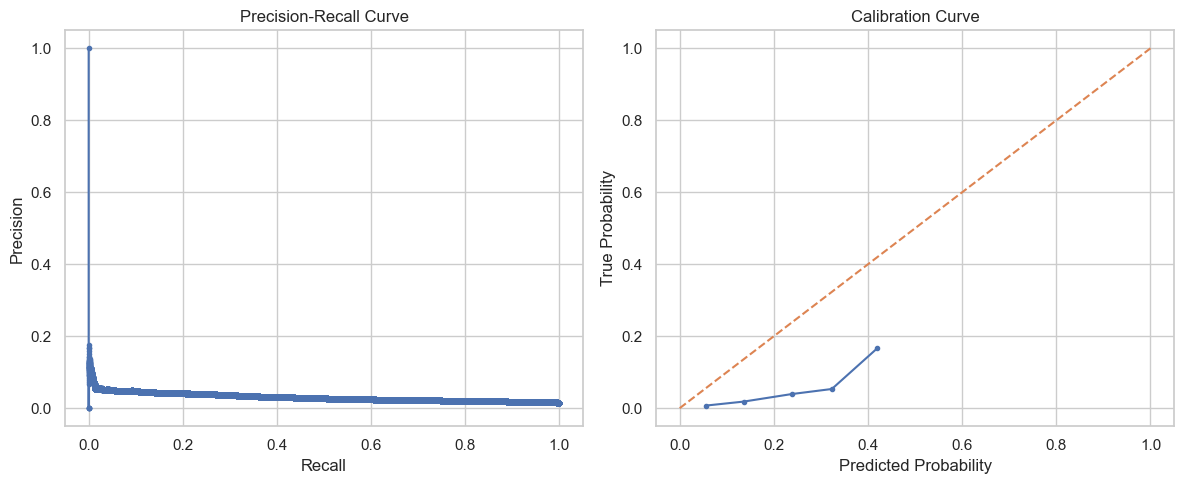

In [15]:
# PR Curve and Calibration curve
plot_pr_calib_curve(y_pred_tunned, y_validation)

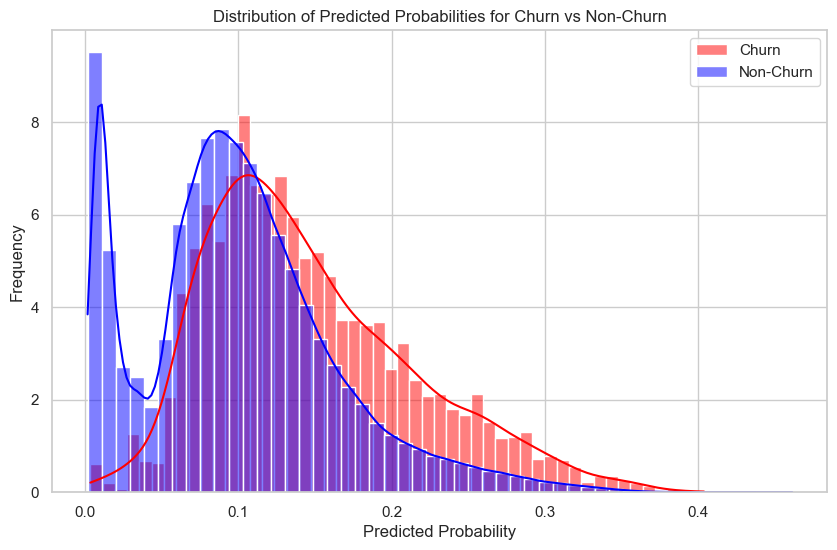

In [16]:
# Distribution of predicted probabilities
plot_dis_probs(y_pred_tunned, y_validation)

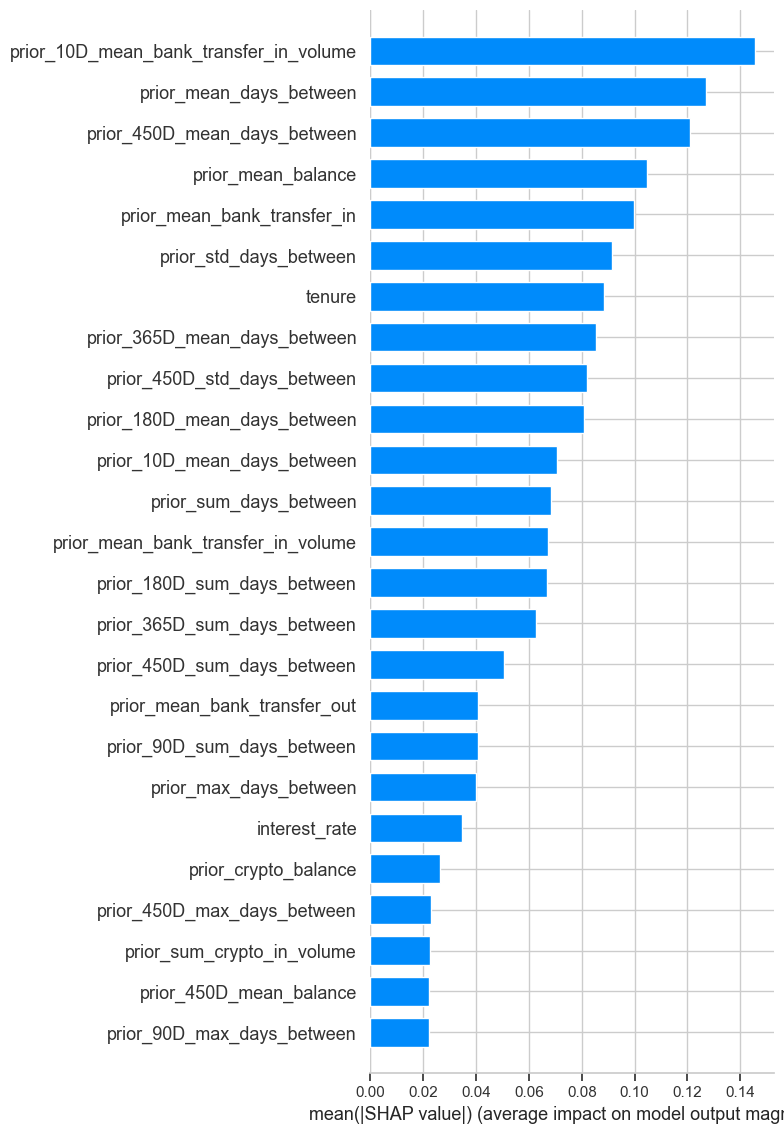

In [17]:
# SHAP Values
shape_explainer = shap.Explainer(model_tunned)
shape_values = shape_explainer(X_validation[selected_features])
plot_shap_values(shape_values, X_validation[selected_features], y_validation)

# Comparing the models

In [18]:
# Load the baseline and feature selection models
baseline_model_path = './week_1/model/baseline_model.joblib'
feat_selection_model_path = './week_1/model/feat_selection_model.joblib'

baseline_model = joblib.load(baseline_model_path)
feat_selection_model = joblib.load(feat_selection_model_path)

# Predict using the baseline model
y_pred_baseline = baseline_model.predict_proba(X_validation)[:, 1]

# Predict using the feature selection model
y_pred_feat_selection = feat_selection_model.predict_proba(X_validation[selected_features])[:, 1]

# Compare the models using clf_metric_report
print("Baseline Model Metrics:")
clf_metric_report(y_pred_baseline, y_validation)

print("\nFeature Selection Model Metrics:")
clf_metric_report(y_pred_feat_selection, y_validation)

print("\nTuned Model Metrics:")
clf_metric_report(y_pred_tunned, y_validation)

Baseline Model Metrics:
Evaluating the model...
ROC AUC: 0.6875439449160486
Brier Score: 0.2730737709354388
Average Precision: 0.028297423279297983
Log Loss: 0.7281983181929271

Feature Selection Model Metrics:
Evaluating the model...
ROC AUC: 0.7010793500287231
Brier Score: 0.2791466657487489
Average Precision: 0.031039970123762507
Log Loss: 0.7437834184928249

Tuned Model Metrics:
Evaluating the model...
ROC AUC: 0.694073800885851
Brier Score: 0.02399945941873523
Average Precision: 0.030776730437567037
Log Loss: 0.13471801061485517


In [20]:
# Save the model trained with selected features
tunned_model_path = './week_1/model/tunned_model.joblib'
joblib.dump(model_tunned, tunned_model_path)

print(f"Baseline model saved to: {tunned_model_path}")

Baseline model saved to: ./week_1/model/tunned_model.joblib
